In [1]:
import time, numpy as np, matplotlib.pyplot as plt
# PyTorch
import torch
from torch.nn.utils import parameters_to_vector, vector_to_parameters

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import models

model = models.Net()

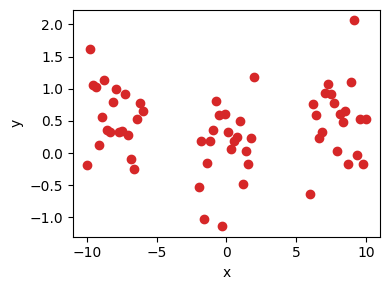

In [3]:
def featurize(x):
    return torch.cat([x[:, None], x[:, None]**2], dim=1)

x = torch.cat([torch.linspace(start=-10, end=-6, steps=20, dtype=torch.float),
               torch.linspace(start= -2, end= 2, steps=20, dtype=torch.float),
               torch.linspace(start=  6, end=10, steps=20, dtype=torch.float)])
f = featurize(x)
y = model(f).detach() + torch.randn(60,1)*0.5

ncols, nrows = 1, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 3*nrows))
axs.scatter(x, y, color='#D62728')
axs.set_xlabel('x')
axs.set_ylabel('y')
fig.tight_layout()
plt.show()

In [4]:
def mse_loss(y_hat, y):
    return torch.mean((y - y_hat) ** 2)

def l2_penalty(params):
    return (1/2) * torch.sum(params ** 2)

In [5]:
lr, weight_decay = 1e-2, 1e-2
model = models.Net()
init = parameters_to_vector(model.parameters()).detach().numpy()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [6]:
start = time.time()
from_scratch_grads = []
for epoch in range(1_000):
    optimizer.zero_grad()
    y_hat = model(f)
    nll = mse_loss(y_hat, y)
    loss = nll + weight_decay * l2_penalty(parameters_to_vector(model.parameters()))
    loss.backward()
    if epoch < 5:
        print(f'Epoch: {epoch}, NLL: {nll.item()}')
        grads = torch.cat([param.grad.view(-1) for param in model.parameters()]).detach().numpy()
        from_scratch_grads.append(grads)
    optimizer.step()

linspace = torch.linspace(start=-10, end=10, steps=100, dtype=torch.float)
from_scratch_preds = model(featurize(linspace))
end = time.time()
print(f'Elapsed time: {end - start}')

Epoch: 0, NLL: 0.34148409962654114
Epoch: 1, NLL: 0.3035143315792084
Epoch: 2, NLL: 0.29991042613983154
Epoch: 3, NLL: 0.297762930393219
Epoch: 4, NLL: 0.29601001739501953
Elapsed time: 0.9506773948669434


In [7]:
model = models.Net()
vector_to_parameters(torch.tensor(init), model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=weight_decay)

In [8]:
start = time.time()
pytorch_grads = []
for epoch in range(1_000):
    optimizer.zero_grad()
    y_hat = model(f)
    nll = mse_loss(y_hat, y) 
    nll.backward()
    if epoch < 5:
        print(f'Epoch: {epoch}, NLL: {nll.item()}')
        params = torch.cat([param.view(-1) for param in model.parameters()]).detach().numpy()
        grads = torch.cat([param.grad.view(-1) for param in model.parameters()]).detach().numpy()
        grads = grads + weight_decay*params
        pytorch_grads.append(grads)
    optimizer.step()

pytorch_preds = model(featurize(linspace))
end = time.time()
print(f'Elapsed time: {end - start}')

Epoch: 0, NLL: 0.34148409962654114
Epoch: 1, NLL: 0.3035143315792084
Epoch: 2, NLL: 0.29991042613983154
Epoch: 3, NLL: 0.297762930393219
Epoch: 4, NLL: 0.29601001739501953
Elapsed time: 0.6904726028442383


In [9]:
for from_scratch_grad, pytorch_grad in zip(from_scratch_grads, pytorch_grads):
    print(np.linalg.norm(from_scratch_grad - pytorch_grad))

0.0
0.0
0.0
0.0
0.0


In [10]:
model = models.Net()
vector_to_parameters(torch.tensor(init), model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
tau = 1/(len(y)*weight_decay)
prior = torch.distributions.normal.Normal(0, np.sqrt(tau))

In [11]:
start = time.time()
bayesian_grads = []
for epoch in range(1_000):
    optimizer.zero_grad()
    y_hat = model(f)
    nll = mse_loss(y_hat, y) 
    loss = nll - (1/len(y)) * torch.sum(prior.log_prob(parameters_to_vector(model.parameters())))
    #loss = nll - (1/len(y)) * - (1 / (2 * tau)) * torch.sum(np.log(1/np.sqrt(2 * np.pi * tau)) / - (1 / (2 * tau)) + (parameters_to_vector(model.parameters()) - 0) ** 2)
    loss.backward()
    if epoch < 5:
        print(f'Epoch: {epoch}, NLL: {nll.item()}')
        grads = torch.cat([param.grad.view(-1) for param in model.parameters()]).detach().numpy()
        bayesian_grads.append(grads)
    optimizer.step()

bayesian_preds = model(featurize(linspace))
end = time.time()
print(f'Elapsed time: {end - start}')

Epoch: 0, NLL: 0.34148409962654114
Epoch: 1, NLL: 0.3035143315792084
Epoch: 2, NLL: 0.29991042613983154
Epoch: 3, NLL: 0.297762930393219
Epoch: 4, NLL: 0.29601001739501953
Elapsed time: 1.043891429901123


In [12]:
for bayesian_grad, pytorch_grad in zip(bayesian_grads, pytorch_grads):
    print(np.linalg.norm(bayesian_grad - pytorch_grad))

6.3539236e-09
1.26172655e-08
8.680424e-09
1.02309174e-08
7.843874e-09


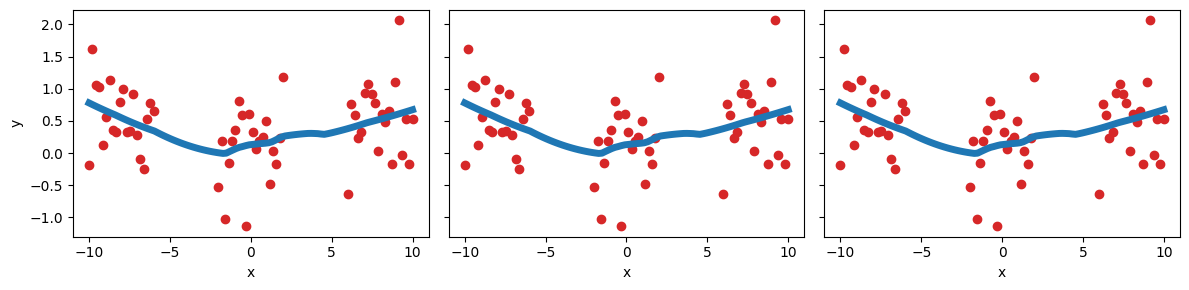

In [13]:
ncols, nrows = 3, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 3*nrows), sharey=True)
axs[0].scatter(x, y, color='#D62728')
axs[0].plot(linspace.data.numpy(), from_scratch_preds.data.numpy(), color='#1F77B4', lw=5)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].scatter(x, y, color='#D62728')
axs[1].plot(linspace.data.numpy(), pytorch_preds.data.numpy(), color='#1F77B4', lw=5)
axs[1].set_xlabel('x')
axs[2].scatter(x, y, color='#D62728')
axs[2].plot(linspace.data.numpy(), bayesian_preds.data.numpy(), color='#1F77B4', lw=5)
axs[2].set_xlabel('x')
fig.tight_layout()
plt.show()